## Прогнозирование оттока клиентов. Телеком

В текущей работе нам предоставлены данные о пользователях мобильного оператора: об их тарифах, подключенных услугах, оплате, и т.д. 
Наша цель, основываясь на предоставленных данных, найтимодель успешно предсказывающую пользователей, кто с большой вероятность мождет прекратить пользоваться услугами оператора в скором времени. Это поможет компании предотвращать уход клиента, предлагая специальные условия.

## Первичный анализ данных

### Загрузка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import inflection

from phik.report import plot_correlation_matrix
from phik import report

from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,  roc_curve
from sklearn.pipeline import Pipeline, make_pipeline

In [3]:
# убираем оповещения
import warnings
warnings.filterwarnings('ignore')

In [4]:
# загружаем доступные данные
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')    

except:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')

In [5]:
# рассмотрим данные
all = [contract, personal, internet, phone]
for i in all:
    print('**'*25)
    print(i.info())
    print(i.describe())
    display(i.head(3))
    print('--'*25)

**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


--------------------------------------------------
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


--------------------------------------------------
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1   

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


--------------------------------------------------
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


--------------------------------------------------


### Промежуточный вывод
Нам доступны три таблицы с данными о разных услугах клиентов оператора. Видно, что данных разное количество. Предположительно, потому что не все клиенты пользуются, всем спектром доступных услуг. Для дальнейшей работы будем объединять таблицы по признаку customerID. При их объединении, предполагается появление пропусков в зависимости от набора используемых услуг.

Данные имеют множество категориальных признаков,а также дат. Эти признаки будем преобразовывать в доступные для использования в обучении модели. 

Целевой признак в прямом виде в данных отсутствует. По смыслу, целевым признаком является уход или продолжение обслуживания клиента в компании. Поэтому мы рассмотрим колонку о дате окончания договора с клиентом, и при отсутсвие даты, будем считать что такой клиент остался и продолжает пользоваться услугами компании. Получается, мы имеем задачу классификации. 

### Предобработка данных 

In [6]:
# объединяем таблицы
data = contract.merge(personal, how = 'outer', on = 'customerID')
data = data.merge(internet,how = 'outer', on = 'customerID')
data = data.merge(phone, how = 'outer', on = 'customerID')

In [7]:
data.info()
display(data.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [8]:
# для удобства работы уберём заглавные буквы из названий
data.columns = [inflection.underscore(column) for column in data.columns]

In [9]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [10]:
# создаём колонку с целевым признаком
data['target_case'] = (data['end_date'] !='No').astype(int)

In [11]:
data.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target_case
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0


In [12]:
# проверим, что целевой признак создан правильно и пропусков не осталось
data['target_case'].info()
data['target_case'].value_counts()

<class 'pandas.core.series.Series'>
Int64Index: 7043 entries, 0 to 7042
Series name: target_case
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 110.0 KB


0    5942
1    1101
Name: target_case, dtype: int64

Можно наблюдать, что в наших данных присутсвует дисбаланс классов. Будем учитывать это при делении данных на тренировочную и тестовую выборки.

Переведём столбцы с данами в формат даты. Поскольку доступная нам информация, актуальна на 1 февраля 2020, то для дальнейшего вычисления продолжительности обслуживания клиента в компании, все пропуски заполним даной 2020-02-01 

In [13]:
data['begin_date'] = pd.to_datetime(data['begin_date'],format = '%Y-%m-%d')
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'
data['end_date'] = pd.to_datetime(data['end_date'],format = '%Y-%m-%d', errors = 'coerce')

In [14]:
# введём новый признак: продолжительность обслуживания
data['time_of_use'] = data['end_date'] - data['begin_date']
data['time_of_use'] = data['time_of_use'].dt.total_seconds().astype('int64')
data['time_of_use'] = data['time_of_use']/86400

In [15]:
# переведём общие затраты клиентов за всё время в числовой тип и заполним пропуски нулями, 
# поскольку значит клиент ещё не начал оплачивать услуги
data['total_charges'] = data['total_charges'].replace(" ", float('nan'))
data['total_charges'] = pd.to_numeric(data['total_charges'])
data['total_charges'].isna().sum()

11

In [16]:
data['total_charges'] = data['total_charges'].fillna(0)
data['total_charges'].isna().sum()

0

Предположу, что если у пользователя не определено наличие таких сервисов как интернет, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies и multiplelines, то можно считать, что их нет. Потому что вряд ли клиенты имели дополнительные услуги и не платили за них.  

Поэтому заменим все пропуски в этих признаках на 'No'. 

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [18]:
data = data.fillna('No')

На данном этапе я предлагаю удалить столбцы о начале и окончании использования услуг. Данные об окончании мы перенесли в целевой пизнак: target_case. Общую продолжительность обслуживания у оператора, мы так же вычислили и поместили в столбец time_of_use. Поэтому удаляем столбцы begin_date и end_date.

Так же удалим customerid, потому что после обьединения таблиц по нему, далее он не понадобиться.

In [19]:
data = data.drop(columns=['begin_date', 'end_date', 'customer_id'])

### Визуализация доступных данных

#### в зависимости от возраста клиента

Рассмотрим разброс доступных нам количественных признаков: оплата за месяц, продолжительность обслуживания клиента в зависимости от категории возраста клиента. 

In [20]:
# разделим данные на людей в возрасте и остальных
senior_charges = data.loc[data['senior_citizen'] == 1,'monthly_charges']
young_charges = data.loc[data['senior_citizen'] == 0,'monthly_charges']

In [21]:
# рассмотрим сколько вообще у нас клиентов разного возраста
data['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

Интересно, что соотношение клиентов 'в возрасте', к оставшимся, примерно такое же как соотношение людей закончивших обслуживание у данного оператора, ко всем клиентам, и составляет около 15%.
Однако, вряд ли эти значения имеют связь. Проверим мы это позже.

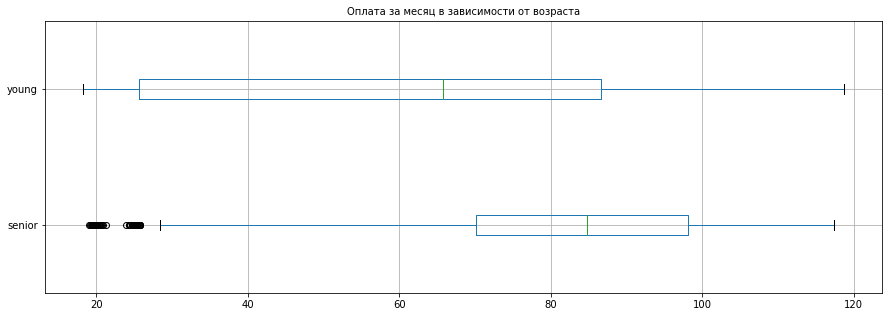

In [22]:
# рассмотрим как зависит размер месячной оплаты услуг в зависимости от возраста клиента
fig, ax = plt.subplots(figsize=(15, 5))

df = pd.concat([senior_charges, young_charges], axis=1)
df.columns = ['senior', 'young']

df.boxplot(ax=ax, vert=False)
ax.set_title('Оплата за месяц в зависимости от возраста', fontsize=10)

plt.show()

In [23]:
df.describe()

,senior,young
count,1142.000000,5901.000000
mean,79.820359,61.847441
std,23.764027,30.316041
min,18.950000,18.250000
25%,70.150000,25.600000
50%,84.850000,65.800000
75%,98.075000,86.700000
max,117.450000,118.750000


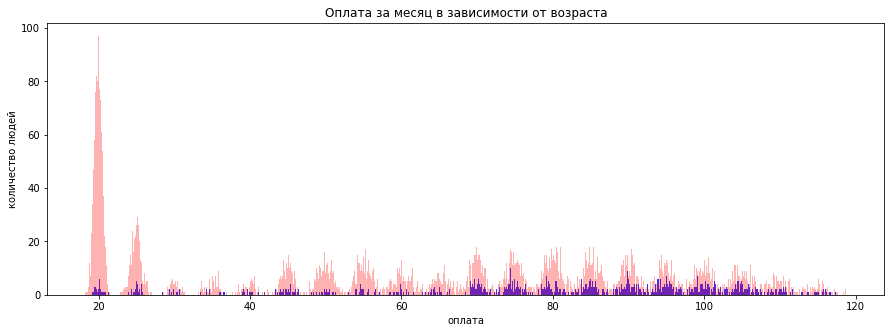

In [24]:
figsize(15, 5)
senior_charges.plot(kind = 'hist', bins=1000,color = 'blue', alpha=0.8)
young_charges.plot(kind='hist', bins=1000,color = 'red', alpha=0.3)

plt.title('Оплата за месяц в зависимости от возраста')

plt.xlabel('оплата')
plt.ylabel("количество людей")
plt.show()

Можно видеть, что средняя сумма оплаты в месяц, у категории "люди в возрасте" на 20 условных единиц больше чем у остальных, что заметно больше, учитывая что разброс данных до 120 у.е..
Также похоже люди часто платят в месяц какие-то круглые суммы, кратные пяти. А количество людей "не в возрасте", оплачивающих минимум за услуги, наибольшее количество.

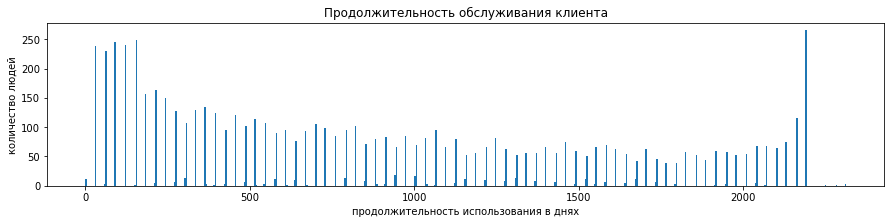

In [25]:
# рассмотрим разброс продолжительности обслуживания клиентов
figsize(15, 3)
data['time_of_use'].plot(kind = 'hist', bins=500, alpha=1,  title = 'Продолжительность обслуживания клиента')
plt.xlabel('продолжительность использования в днях')
plt.ylabel('количество людей')
plt.show()

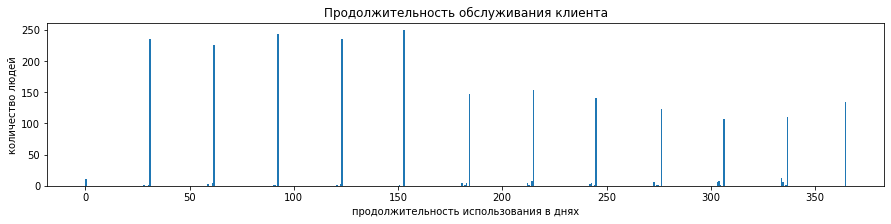

In [26]:
# рассмотрим данные ограничившись одним годом
figsize(15, 3)
data['time_of_use'].plot(kind = 'hist', bins=500, range=(0, 365),  title = 'Продолжительность обслуживания клиента')
plt.xlabel('продолжительность использования в днях')
plt.ylabel('количество людей')
plt.show()

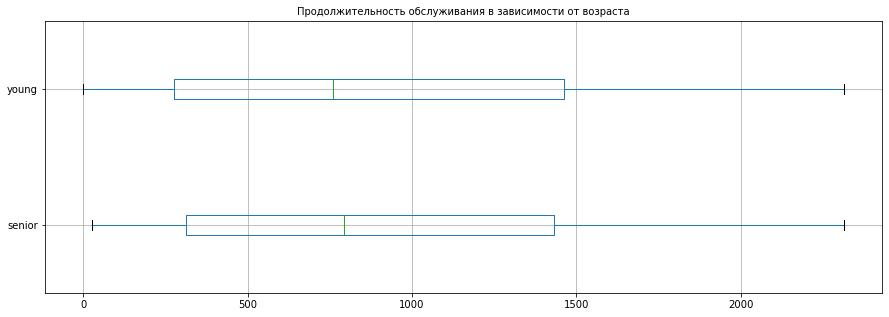

In [27]:
senior_use = data.loc[data['senior_citizen'] == 1,'time_of_use']
young_use = data.loc[data['senior_citizen'] == 0,'time_of_use']

fig, ax = plt.subplots(figsize=(15, 5))
df = pd.concat([senior_use, young_use], axis=1)
df.columns = ['senior', 'young']

df.boxplot(ax=ax, vert=False)
ax.set_title('Продолжительность обслуживания в зависимости от возраста', fontsize=10)

plt.show()

Видим, что разброс и средняя продолжительности обслуживания людей двух возрастных категорий, очень близки.

Из графика похоже, что данные о времени пользования услугами, чаще всего кратны продолжительности месяца.

#### в зависимости от значения целевого признака

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

Намного более интересно рассмотреть месячную оплату клиентов и продолжительность их обслуживания в зависимости от того ушел клиент или продолжает обслуживаться

In [29]:
left_time_of_use = data.loc[data['target_case'] == 1,'time_of_use']
stayed_time_of_use = data.loc[data['target_case'] == 0,'time_of_use']

left_monthly_charges = data.loc[data['target_case'] == 1,'monthly_charges']
stayed_monthly_charges = data.loc[data['target_case'] == 0,'monthly_charges']

left_total_charges = data.loc[data['target_case'] == 1,'total_charges']
stayed_total_charges = data.loc[data['target_case'] == 0,'total_charges']

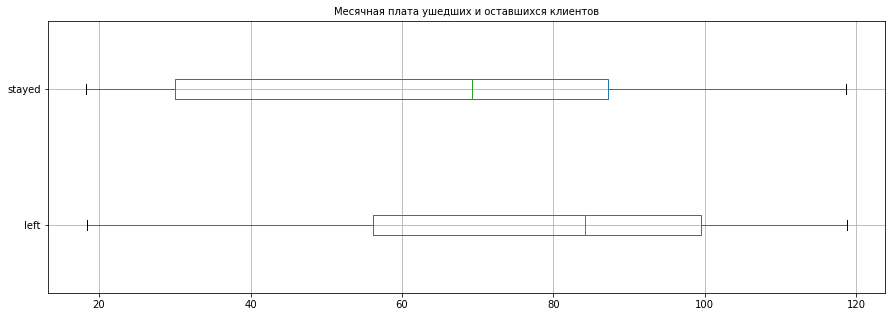

In [30]:
# месячная плата у ушедших и оставшихся клиентов
fig, ax = plt.subplots(figsize=(15, 5))

df = pd.concat([left_monthly_charges, stayed_monthly_charges], axis=1)
df.columns = ['left', 'stayed']

df.boxplot(ax=ax, vert=False)
ax.set_title('Месячная плата ушедших и оставшихся клиентов', fontsize=10)

plt.show()

In [31]:
df.describe()

,left,stayed
count,1101.000000,5942.000000
mean,75.546004,62.763455
std,29.116213,29.844462
min,18.400000,18.250000
25%,56.150000,30.062500
50%,84.200000,69.200000
75%,99.500000,87.237500
max,118.750000,118.600000


In [32]:
color = sns.color_palette(palette='bright', n_colors=2, desat=None, as_cmap=False)

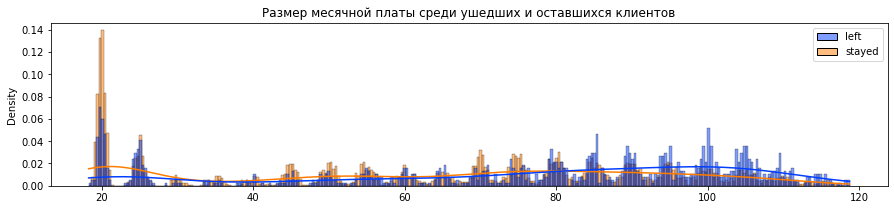

In [33]:
# визуализируем графиком плотности
sns.histplot(data=df, bins=300, stat='density',palette = color,  kde = True, common_norm=False);
plt.title("Размер месячной платы среди ушедших и оставшихся клиентов");
plt.show()

Можно заметить, что месячная оплата ушедших клиентов, в среднем была на 16 у.е. выше, тех кто остался. По графику плотности, также можно видеть, что высокая месячная оплата чаще всего встречалась у ушедших клиентов.

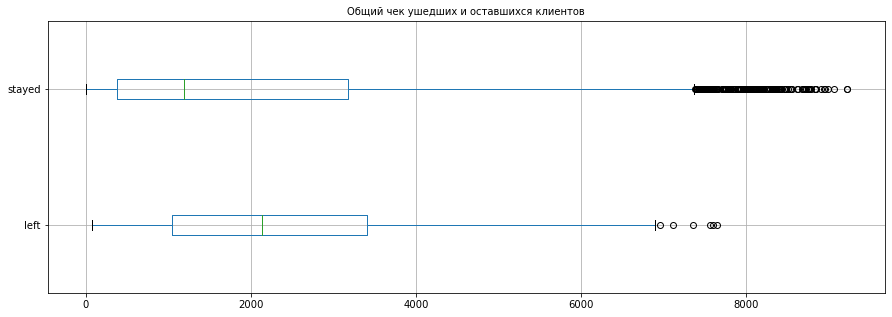

In [34]:
# общий счёт у ушедших и оставшихся клиентов
fig, ax = plt.subplots(figsize=(15, 5))

df = pd.concat([left_total_charges, stayed_total_charges], axis=1)
df.columns = ['left', 'stayed']

df.boxplot(ax=ax, vert=False)
ax.set_title('Общий чек ушедших и оставшихся клиентов', fontsize=10)

plt.show()

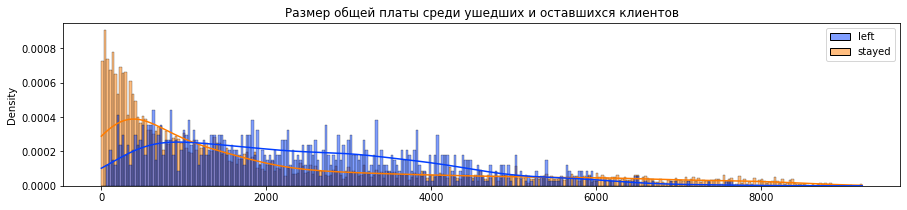

In [35]:
sns.histplot(data=df, bins=300, stat='density',palette = color,  kde = True, common_norm=False);
plt.title("Размер общей платы среди ушедших и оставшихся клиентов");

Общий чек за всё время обслуживания, также больше у ушедших клиентов.

Однако, размер общей платы имеет смысл рассматривать лишь в соответсвии с продолжительностью обслуживания. Поэтому ниже рассмотрим продолжительность обслуживания двух категорий клиентов, и затем построим зависимость общего чека от продолжительности обслуживания, для двух категорий.

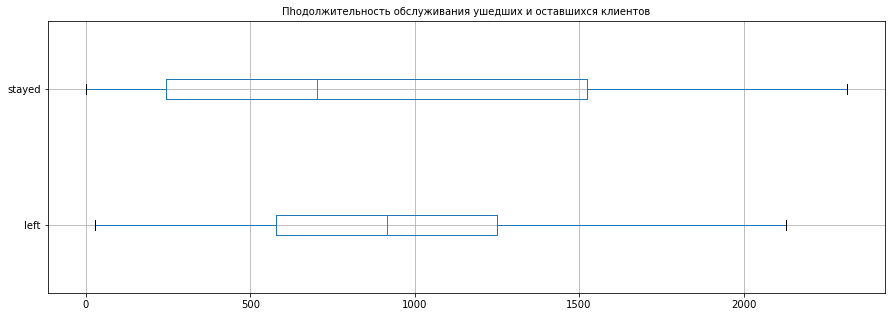

In [36]:
# время пользования услугами компании у ушедших и оставшихся клиентов
fig, ax = plt.subplots(figsize=(15, 5))

df = pd.concat([left_time_of_use, stayed_time_of_use], axis=1)
df.columns = ['left', 'stayed']

df.boxplot(ax=ax, vert=False)
ax.set_title('Пhодолжительность обслуживания ушедших и оставшихся клиентов', fontsize=10)

plt.show()

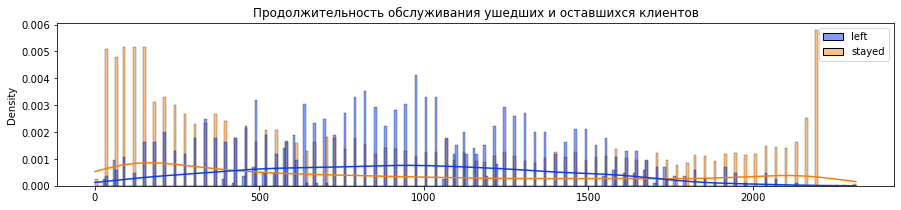

In [37]:
sns.histplot(data=df, bins=300, stat='density',palette = color,  kde = True, common_norm=False);
plt.title("Продолжительность обслуживания ушедших и оставшихся клиентов");

In [38]:
df = pd.concat([left_time_of_use, stayed_time_of_use, left_total_charges, stayed_total_charges], axis=1)
df.columns = ['left_time_of_use', 'stayed_time_of_use', 'left_total_charges', 'stayed_total_charges']

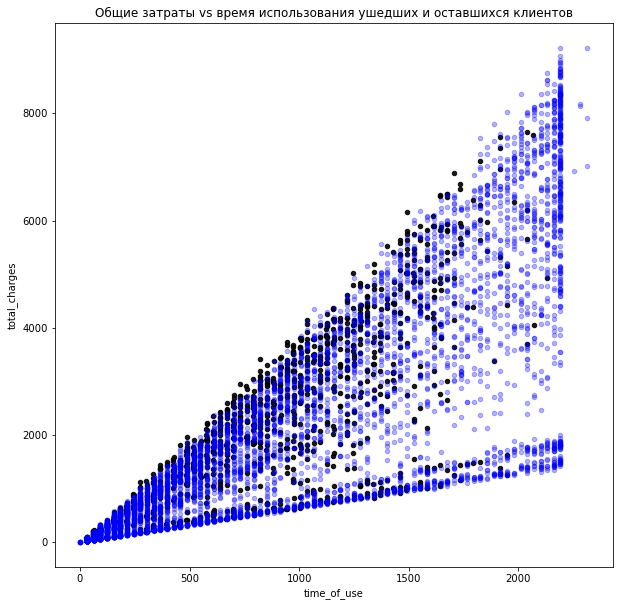

In [39]:
fig, ax = plt.subplots(figsize = (10,10))
df.plot(x= 'left_time_of_use', y='left_total_charges', kind='scatter', alpha = 0.9, ax = ax, color = 'black')
df.plot(x= 'stayed_time_of_use', y='stayed_total_charges', kind='scatter', alpha = 0.3, ax = ax, color = 'blue')

ax.set_xlabel('time_of_use')
ax.set_ylabel('total_charges')
ax.set_title('Общие затраты vs время использования ушедших и оставшихся клиентов')
plt.show()

Последний график хорошо показывает, что даже, если месячная оплата ушедших клиентов в среднем выше тех, кто остался, то общие затраты за всё время обслуживания ушедших и оставшихся клиентов схожи. 

Интересно, что похоже есть какие-то два тарифа с отличительно более низкой месячной оплатой - такой вывод можно сделать если аппроксимировать точки внизу графика и построить по ним две линии тренда.

### Корреляция признаков

Теперь рассмотрим, присутсвует ли в наших данных мультиколлинеарности.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target_case', 'time_of_use']


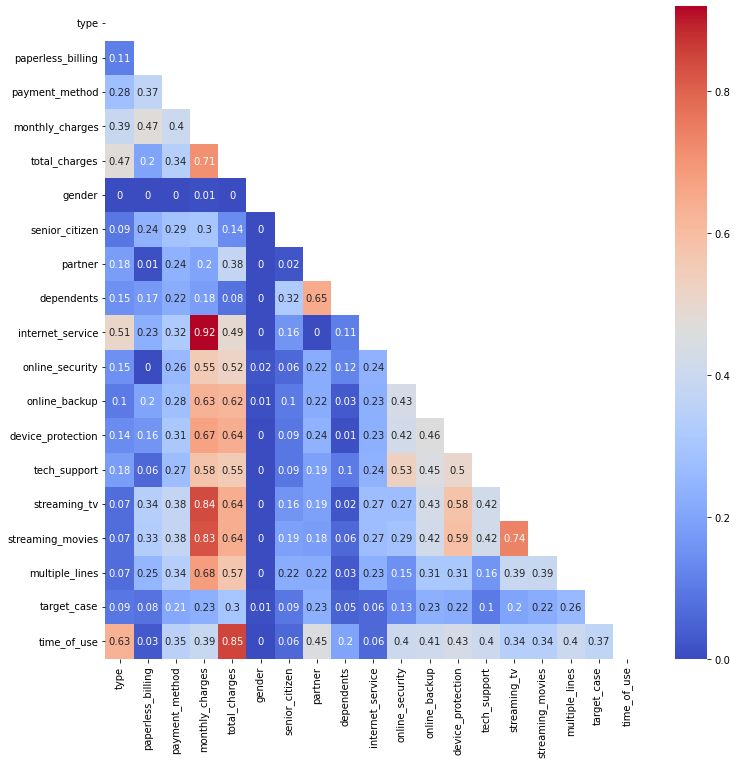

In [40]:
# рассмотрим корреляцию признаков
figsize(12, 12)
phik_overview = round(data.phik_matrix(), 2)
mask = np.triu(np.ones_like(phik_overview, dtype=bool))
sns.heatmap(phik_overview, annot = True, cmap = 'coolwarm', mask=mask)
plt.show()

Видим высокую причино-следственную связь между рамером месячной оплаты услуг и использованием интернета, телевиления и подписки на фильмы. Так же общий счёт за вс время коррелирует с тем, сколько человек пользуется услугами компании, что довольно логично.

## Подбор оптимальной модели

Делим данные на выборки с учётом дисбаланса классов

In [41]:
train, test = train_test_split(data, stratify = data['target_case'], test_size=0.25, random_state=50623)

In [42]:
features_train = train.drop(['target_case'], axis = 1)
target_train = train['target_case']

features_test = test.drop(['target_case'], axis = 1)
target_test = test['target_case']

Перед нами задача классификации. Будем подбирать параметры GradientBoostingClassifier и RandomForestClassifier

### RandomForestClassifier

В наших данные присутствуют категориальные и количественные признаки. Для корректной работы модели, категориальные признаки нам надо закодировать, а количественные масштабировать. Всё это будем делать в рамкаш пайплайна при подюоре гиперпараметров в кросс-валидации моделей.

Оценивать работу моделией будем по метрике ROC-AUC.  ROC-AUC показывает площадь под кривой ошибок (ROC-кривой). Кривая отрадает баланс модели по ложноположительным и истинно положительным ответам. Случайная модель будет иметь метрику ROC-AUC равную 0.5. С улучшением качества модели, метрика бкдет стремиться к еденице.

In [43]:
categorial_features = ['type', 'paperless_billing', 'payment_method','gender', 'partner', 'dependents',\
                       'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',\
                       'streaming_tv','streaming_movies', 'multiple_lines']
data_unique = data[categorial_features].nunique()
display(data_unique)

type                 3
paperless_billing    2
payment_method       4
gender               2
partner              2
dependents           2
internet_service     3
online_security      2
online_backup        2
device_protection    2
tech_support         2
streaming_tv         2
streaming_movies     2
multiple_lines       2
dtype: int64

In [44]:
numeric = ['monthly_charges','total_charges', 'time_of_use']

In [45]:
print(len(categorial_features))
print(len(numeric))

14
3


In [46]:
%%time
ohe = OneHotEncoder(drop='first' , handle_unknown='ignore', sparse=False)
scaler = StandardScaler()

transformer = ColumnTransformer(transformers=[('scaler', scaler, numeric), ('ohe', ohe, categorial_features)],\
                                remainder='passthrough')

model_rf = RandomForestClassifier(random_state=50623)

pipe_rf = Pipeline(steps=[('transformer', transformer), ('model_rf', model_rf)])

params_rf = {'model_rf__n_estimators':[500, 1000, 1500],
            'model_rf__max_depth':[5,10,20, 100]}


search_rf= GridSearchCV(pipe_rf, params_rf,n_jobs=-1,scoring ='roc_auc', cv=5, verbose=True)
search_rf.fit(features_train,target_train)
print(search_rf.best_params_)
print(search_rf.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'model_rf__max_depth': 10, 'model_rf__n_estimators': 500}
0.8216847636912187
CPU times: user 1.94 s, sys: 24.5 ms, total: 1.97 s
Wall time: 58.8 s


In [47]:
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'model_rf', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__scaler', 'transformer__ohe', 'transformer__scaler__copy', 'transformer__scaler__with_mean', 'transformer__scaler__with_std', 'transformer__ohe__categories', 'transformer__ohe__drop', 'transformer__ohe__dtype', 'transformer__ohe__handle_unknown', 'transformer__ohe__sparse', 'model_rf__bootstrap', 'model_rf__ccp_alpha', 'model_rf__class_weight', 'model_rf__criterion', 'model_rf__max_depth', 'model_rf__max_features', 'model_rf__max_leaf_nodes', 'model_rf__max_samples', 'model_rf__min_impurity_decrease', 'model_rf__min_samples_leaf', 'model_rf__min_samples_split', 'model_rf__min_weight_fraction_leaf', 'model_rf__n_estimators', 'model_rf__n_jobs', 'model_rf__oob_score', 'model_rf__random_state', 'mode

### GradientBoostingClassifier

In [55]:
%%time

model_gb = GradientBoostingClassifier(random_state=50623)
pipe_gb = Pipeline(steps=[('transformer', transformer), ('model_gb', model_gb)])

params_gb = {'model_gb__learning_rate':[0.01, 0.05, 0.1],
            'model_gb__max_depth':[5,10],
            'model_gb__n_estimators':[5,50,100,250,500]}

search_gb = GridSearchCV(pipe_gb, params_gb, cv=5, n_jobs=-1,scoring ='roc_auc',verbose=True)

search_gb.fit(features_train,target_train)
print(search_gb.best_params_)
print(search_gb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'model_gb__learning_rate': 0.1, 'model_gb__max_depth': 5, 'model_gb__n_estimators': 500}
0.8929544986214741
CPU times: user 5.52 s, sys: 19.2 ms, total: 5.54 s
Wall time: 2min 7s


In [56]:
pipe_gb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'model_gb', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__scaler', 'transformer__ohe', 'transformer__scaler__copy', 'transformer__scaler__with_mean', 'transformer__scaler__with_std', 'transformer__ohe__categories', 'transformer__ohe__drop', 'transformer__ohe__dtype', 'transformer__ohe__handle_unknown', 'transformer__ohe__sparse', 'model_gb__ccp_alpha', 'model_gb__criterion', 'model_gb__init', 'model_gb__learning_rate', 'model_gb__loss', 'model_gb__max_depth', 'model_gb__max_features', 'model_gb__max_leaf_nodes', 'model_gb__min_impurity_decrease', 'model_gb__min_samples_leaf', 'model_gb__min_samples_split', 'model_gb__min_weight_fraction_leaf', 'model_gb__n_estimators', 'model_gb__n_iter_no_change', 'model_gb__random_state', 'model_gb__subsample', 'model

Гораздо лучшую метрику ROC-AUC показывает модель GradientBoostingClassifier. А время работы моделей для решения нашей задачи отличается не критично.

## Применяем модель к тестовой выборке

Найдём самые успешные параметры, подобранные на предыдущем этапе

In [57]:
search_gb.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'time_of_use']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'partner', 'dependents',
                                                   'internet_service',
               

In [58]:
print(features_train.shape)
print(features_test.shape)

print(target_train.shape)
print(target_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [59]:
%%time
best_model = search_gb.best_estimator_

best_model.fit(features_train,target_train)
prediction_proba = best_model.predict_proba(features_test)[:, 1]
result_proba = roc_auc_score(target_test, prediction_proba)

CPU times: user 4.68 s, sys: 0 ns, total: 4.68 s
Wall time: 4.68 s


In [60]:
print(f'На тестовой выборке получаем значение метрики ROC-AUC методом predict_proba {result_proba:.3}')


На тестовой выборке получаем значение метрики ROC-AUC методом predict_proba 0.917


Мы получили отличный результат. Модель отлично предсказывает с метрикой ROC-AUC = 0.917

### ROC кривая

Визуализируем кривую ошибок нашей модели.

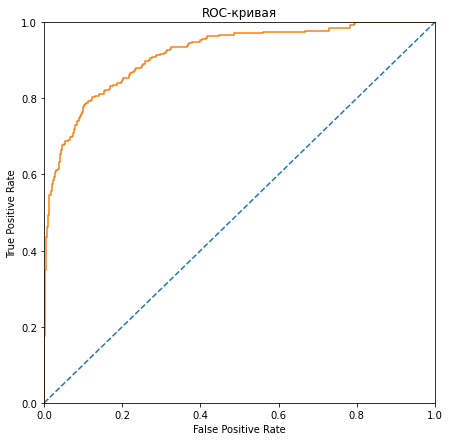

In [61]:
figsize(7,7)

fpr, tpr, thresholds = roc_curve(target_test, prediction_proba)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Важность признаков для модели

In [62]:
feature_importances = best_model.steps[1][1].feature_importances_
sorted_importance = np.argsort(feature_importances)

In [63]:
ohe_names = best_model.steps[0][1].get_feature_names_out()

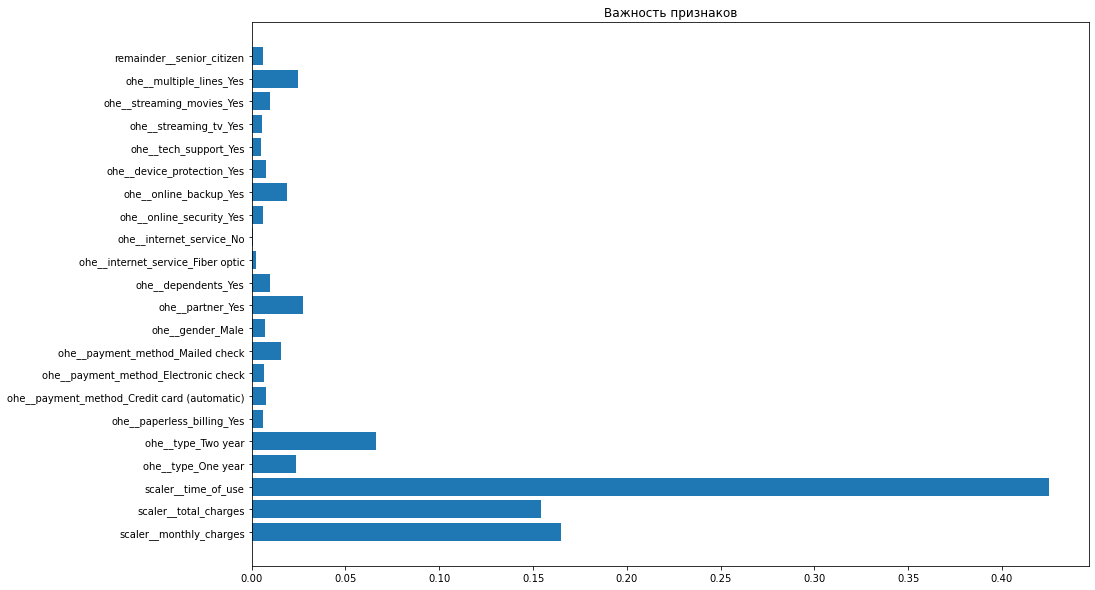

In [64]:
plt.figure(figsize=(15, 10))
plt.barh(sorted_importance, feature_importances[sorted_importance], align='center')
plt.yticks(sorted_importance, ohe_names[sorted_importance])
plt.title('Важность признаков')
plt.show()

Можно видеть, что наибольший вклад в классификацию результата, вносят данные о продолжительности обслуживания клиента. Чуть менее важно, сколько клиент платит каждый месяц и сколько он заплатил за всё время обслуживания в компании. Далее для правильного предсказания моделью, важны такие признаки, как продолжительность договора клиента, наличие партнёра, обслуживающегося в этой же компании, наличие услуги многоканальной телефонии и резервного копирования информации. Все остальные признаки, вносят гораздо меньший вклад в прогнозирование моделью.

## Выводы



В данной работе нам было необходимо подготовить данные и подобрать подходящую модель, для нахождения пользователей с большой вероятностью завершения обслуживания в компании. 

Для этого мы объединили четыре таблицы с личными данными и данными об услугах клиентов. Целевой признак брали из колонки об окончании обслуживания клиента. Если там была дата, отличная от даты выгрузки данных, то целевой признак записывали единицей, в противном случае ставили ноль.
Далее, исходя из дат начала и окончания договора создали дополнительный признак - продолжительность обслуживания клиента. В случае отсутсвии даты окончания обслуживания, использовали дату выгрузки данных.
Данные об общей сумме платежей клиента за всё время, преревели в численный формат. Пропуски сочли отсутсвием платежей.
Пропуски в категориальных признаках, заполнили словом 'No', в качестве категории отсутсвия таких услуг.
Далее провели прямое кодировнаие категориальных признаков, для обучения моделей.

Визуализация данных показала, что средняя месячная оплата ушедших клиентов, была намного выше тех, кто остался. Что гипотетически может быть причиной их ухода.

При обучении модели использовались все признаки, кроме кодового номера клиента, дат начала и окончания обслуживания.А именно 'monthly_charges', 'total_charges', 'senior_citizen', 'time_of_use', 'type_One year', 'type_Two year', 'paperless_billing_Yes', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'internet_service_Fiber optic', 'internet_service_No', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes'

Данные делились на тренировочную и тестовую выборки в соотношении 75/25.

Целевой метрикой в этой работе служила ROC-AUC, оптимально балансирующая между максимумом правильно предсказанных положительных случаев и минимом ошибочно отрицательных вариантов.

Метрику ROC-AUC более 0.89 на тренировочной выборке дала модель со следующими параметрами:

GradientBoostingClassifier (learning_rate=0.1, max_depth=5, n_estimators=500, random_state=50623)

На тестовой выборке метрика ROC-AUC данной модели повысилась до 0.91.

Можно видеть, что наибольший вклад в классификацию результата, вносят данные о продолжительности обслуживания клиента. Чуть менее важно, сколько клиент платит каждый месяц и сколько он заплатил за всё время обслуживания в компании. Далее для правильного предсказания моделью, важны такие признаки, как продолжительность договора клиента, наличие партнёра, обслуживающегося в этой же компании, наличие услуги многоканальной телефонии и резервного копирования информации. Все остальные признаки, вносят гораздо меньший вклад в прогнозирование моделью.

Таким образом нам успешно удалось подобрать модель для предсказания ухода клиентов.